$Yukawa-Video$

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 24 14:29:40 2024

@author: dell
"""

from scipy.special import spherical_jn as jn
from scipy.special import spherical_yn as yn
from scipy.special import lambertw as lamb
from scipy.misc import derivative
from scipy.interpolate import CubicSpline as CS
import matplotlib.pyplot as plt
import numpy as np

def Vpot(r,V0):
    k=1.0
    return -k*np.exp(-r*V0)/r

def rpos(Eval, V0):
    k=1.0
    return lamb(-V0*k/Eval).real #np.sqrt(np.log(-V0/Eval))

def odeeqns(r, y, Mr, l, El, V0):
    theta, omega = y
    return [omega, -2.*Mr*(El-Vpot(r,V0))*theta]

Varray = np.linspace(0.1, 0.8, 270)                 #np.loadtxt("F:/Spyder/potential_depths.dat") + 5.0
y0=[0.,1.]
r=np.linspace(0.001,12.,1500)
rlen = len(r)
Mr=0.95
l=0
V0= np.pi**2/8*0.
r_span = (0.001,12.)

rbsc = []
vbsc = []
Elvls = []
for iEdel in np.linspace(-40.,0.,num=200):
    El=iEdel/800.+0.001
    Elvls.append(El)
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    rbsc.append(np.real(1j*np.power(pmom,2*l+1)))
    vbsc.append(np.real(1j*np.power(-pmom,2*l+1)))
    
Eplvls = np.linspace(0.,100.,num=200)/800.+0.000001

rbsc = np.array(rbsc)
vbsc = np.array(vbsc)
Elvls = np.array(Elvls)

def kmat(V0):
    ktilde = []
    for iEdel in np.linspace(-40.,0.,num=200):
        El=iEdel/800.+0.001
        usol = solve_ivp(odeeqns, r_span,  y0, t_eval= r, args=(Mr, l, El, V0),)

        #ufunc=CS(usol.t, -usol.y[0])
        Rfunc=CS(usol.t[1:], np.lib.scimath.log(usol.y[0][1:]/usol.t[1:])).derivative()

        #Rvals = Rfunc(usol.t)
        ra = 8.
        pmom = np.lib.scimath.sqrt(2*Mr*El)
        def jnfn(x):
            return jn(l, pmom*x)
        def ynfn(x):
            return yn(l, pmom*x)

        num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
        den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)
        ktilde.append(np.real(np.power(pmom,2*l+1)*num/den))
               
    rpsin = CS(Elvls, np.array(ktilde)-rbsc)
    vpsin = CS(Elvls, np.array(ktilde)-vbsc)
    polE = -10. 
    polp = -10.
    uwfnr = 1000.*np.ones(1500)
    uwfny = 1000.*np.ones(1500)
    penh = 1000.*np.ones((len(Eplvls)))
    for sols in rpsin.roots():
        if sols<0:
            if sols>polE:
                polE = sols
                polp = np.real(1j*np.lib.scimath.sqrt(2*Mr*polE))
                uwfn = solve_ivp(odeeqns, r_span, y0, t_eval= r, args=(Mr, l, polE, V0),)
                uwfnr= np.array(uwfn.t)
                uwfny= np.array(uwfn.y[0])
                penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(rpsin(Eplvls),2)
    for sols in vpsin.roots():
        if sols<0:
            if sols>polE:
                polE = sols
                polp = np.real(-1j*np.lib.scimath.sqrt(2*Mr*polE))
                uwfn = solve_ivp(odeeqns, r_span,  y0,t_eval= r, args=(Mr, l, polE, V0),)
                penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(vpsin(Eplvls),2)

    return ktilde, polp, polE, uwfnr, uwfny, penh
          
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
from scipy.integrate import solve_ivp


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.25,hspace=0.25)
fig.suptitle('Pole trajectory in a potential '+r"$V=-V_0~e^{-k*r}/r$", fontsize=21)


def AnimFunction(frame):
    stepval=0.002
    Vvals = np.array([Vpot(ix,Varray[frame]) for ix in r])
    Kvals, poE, pop, uwfnr, uwfny, penh = kmat(Varray[frame])

    ax1.clear()
    ax1.set_ylim(-0.3,0.3)
    ax1.set_xlim(0, 1.)
    ax1.set_xlabel("r",family='sans-serif',fontsize=24,fontstyle='italic')
    ax1.set_ylabel("V",family='sans-serif',fontsize=24,fontstyle='italic')
    ax1.tick_params(axis="x", labelsize=15)
    ax1.tick_params(axis="y", labelsize=15)
    if poE<-0.0001:
        ax1.hlines(poE, 0., rpos(poE,V0+stepval*frame), colors="orange", linestyle="-",)  
    elif poE>0.0001:
        ax1.hlines(-poE, 0., rpos(-poE,V0+stepval*frame), colors="magenta", linestyle="-",)  
    ax1.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax1.plot(r, Vvals, lw=2.5, color="blue", label= f'k ={V0} V0 = 1.0 '  )

    ax2.clear()
    ax2.set_ylim([-0.4,0.4])
    ax2.set_xlim([-0.05,0.001])
    ax2.set_xlabel(r"$p^2$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax2.set_ylabel(r"$p~cot\delta_0$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax2.tick_params(axis="x", labelsize=15)
    ax2.tick_params(axis="y", labelsize=15)
    ax2.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax2.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax2.plot(Elvls, rbsc, color="orange", linestyle="dashed", lw=2.5)
    ax2.plot(Elvls, vbsc, color="cyan", linestyle="dashed", lw=2.5)
    ax2.plot(Elvls, Kvals, lw=2.5, color="red")
    if poE<-0.0001:
        ax2.scatter(np.array([pop]), np.array([poE]), c="orange", s=100, alpha=0.8) 
    elif poE>0.0001:
        ax2.scatter(np.array([pop]), np.array([poE]), c="magenta", s=100, alpha=0.8) 

    ax3.clear()
    ax3.set_ylim(-0.1,1.5)
    ax3.set_xlim(0, 4.)
    ax3.set_xlabel("$r$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax3.set_ylabel("$u$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax3.tick_params(axis="x", labelsize=15)
    ax3.tick_params(axis="y", labelsize=15)
    ax3.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax3.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
    if poE<-0.0001:
        ax3.plot(uwfnr, uwfny, lw=2.5, color="orange", linestyle="dashdot")
    elif poE>0.0001:
        ax3.plot(uwfnr, uwfny, lw=2.5, color="magenta", linestyle="dashdot")
                
    ax4.clear()
    ax4.set_ylim(-0.01,0.2)
    ax4.set_xlim(-0.12, 0.05)
    ax4.set_xlabel(r"$E_{cm}$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax4.set_ylabel(r"$p|t|^2$",family='sans-serif',fontsize=24,fontstyle='italic')
    ax4.tick_params(axis="x", labelsize=15)
    ax4.tick_params(axis="y", labelsize=15)
    ax4.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
    ax4.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
    if poE<-0.0001:
        ax4.scatter(np.array([poE]), np.array([0.0]), c="orange", s=100, alpha=0.8) 
        ax4.plot(Eplvls, penh, lw=2.5, color="red")
    elif poE>0.0001:
        ax4.plot(Eplvls, penh, lw=2.5, color="red")
        ax4.scatter(np.array([-poE]), np.array([0.0]), c="magenta", s=100, alpha=0.8)   
    
anim_created = FuncAnimation(fig, AnimFunction, frames=250, interval=50)#, save_count=150)
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

fig.tight_layout()

anim_created.save('Yukawa.mp4')
plt.close()

C:\Users\dell\AppData\Local\Temp\ipykernel_47372\2269387601.py:70: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_47372\2269387601.py:71: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


C:\Users\dell\AppData\Local\Temp\ipykernel_47372\2269387601.py:70: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_47372\2269387601.py:71: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


$Plots$

In [2]:
from scipy.special import spherical_jn as jn
from scipy.special import spherical_yn as yn
from scipy.special import lambertw as lamb
from scipy.misc import derivative
from scipy.interpolate import CubicSpline as CS
import matplotlib.pyplot as plt
import numpy as np
#from matplotlib.animation import FuncAnimation
#from IPython import display
from scipy.integrate import solve_ivp

In [3]:
def Vpot(r,V0):
    k=1.0
    return -k*np.exp(-r*V0)/r

def rpos(Eval, V0):
    k=1.0
    return lamb(-V0*k/Eval).real #np.sqrt(np.log(-V0/Eval))

def odeeqns(r, y, Mr, l, El, V0):
    theta, omega = y
    return [omega, -2.*Mr*(El-Vpot(r,V0))*theta]

In [4]:
Varray = np.linspace(0.1, 0.8, 270)                 #np.loadtxt("F:/Spyder/potential_depths.dat") + 5.0
rmax = 12.
y0=[0.,1.]
r=np.linspace(0.001,rmax,1500)
Mr=0.95
l=0
r_span = (0.001,rmax)

In [5]:
V0=np.pi**2/8

In [6]:
ktilde = []
rbsc = []
vbsc = []
Elvls = []
for iEdel in np.linspace(-40.,0.,num=200):
    El=iEdel/800.+0.001
    Elvls.append(El)
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    rbsc.append(np.real(1j*np.power(pmom,2*l+1)))
    vbsc.append(np.real(1j*np.power(-pmom,2*l+1)))
    
    usol = solve_ivp(odeeqns, r_span,  y0, t_eval= r, args=(Mr, l, El, V0),)

    #ufunc=CS(usol.t, -usol.y[0])
    Rfunc=CS(usol.t[1:], np.lib.scimath.log(usol.y[0][1:]/usol.t[1:])).derivative()

    #Rvals = Rfunc(usol.t)
    ra = 8.
    pmom = np.lib.scimath.sqrt(2*Mr*El)
    def jnfn(x):
        return jn(l, pmom*x)
    def ynfn(x):
        return yn(l, pmom*x)

    num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
    den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)
    ktilde.append(np.real(np.power(pmom,2*l+1)*num/den))
               
Eplvls = np.linspace(0.,100.,num=200)/800.+0.000001

rbsc = np.array(rbsc)
vbsc = np.array(vbsc)
Elvls = np.array(Elvls)

rpsin = CS(Elvls, np.array(ktilde)-rbsc)
vpsin = CS(Elvls, np.array(ktilde)-vbsc)
polE = -10. 
polp = -10.
uwfnr = 1000.*np.ones(1500)
uwfny = 1000.*np.ones(1500)
penh = 1000.*np.ones((len(Eplvls)))

for sols in rpsin.roots():
    if sols<0:
        if sols>polE:
            polE = sols
            polp = np.real(1j*np.lib.scimath.sqrt(2*Mr*polE))
            uwfn = solve_ivp(odeeqns, r_span, y0, t_eval= r, args=(Mr, l, polE, V0),)
            uwfnr = np.array(uwfn.t)
            uwfny = np.array(uwfn.y[0])
            penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(rpsin(Eplvls),2)
for sols in vpsin.roots():    
    if sols<0:
        if sols>polE:
            polE = sols
            polp = np.real(-1j*np.lib.scimath.sqrt(2*Mr*polE))
            uwfn = solve_ivp(odeeqns, r_span,  y0,t_eval= r, args=(Mr, l, polE, V0),)
            penh = np.sqrt(np.power(2*Mr*Eplvls,3))/np.power(vpsin(Eplvls),2)
    


C:\Users\dell\AppData\Local\Temp\ipykernel_47372\2650773848.py:25: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  num = yn(l, pmom*ra)*Rfunc(ra) - derivative(ynfn, ra, dx=0.00001)
C:\Users\dell\AppData\Local\Temp\ipykernel_47372\2650773848.py:26: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  den = jn(l, pmom*ra)*Rfunc(ra) - derivative(jnfn, ra, dx=0.00001)


NameError: name 'poE' is not defined

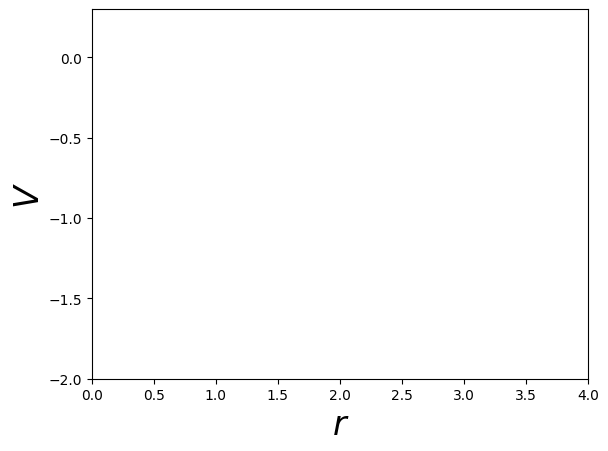

In [7]:
plt.ylim(-2.0,0.3)
plt.xlim(0, 4.)
plt.xlabel("r",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel("V",family='sans-serif',fontsize=24,fontstyle='italic')
if polp<-0.001:
    plt.hlines(polp, 0., rpos(poE,V0), colors="orange", linestyle="-",)  # rpos(polp,V0),'''
elif polp>0.001:
    plt.hlines(-polp, 0., rpos(-poE,V0), colors="magenta", linestyle="-",)  #''' rpos(-polp,V0),'''
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.plot(r, Vpot(r,V0), lw=2.5, color="blue")
print("V0 = " ,V0 , ", Polp = ", polp)

In [ ]:
plt.ylim([-0.4,0.4])
plt.xlim([-0.05,0.001])
plt.xlabel(r"$p^2$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel(r"$p~cot\delta_0$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.plot(Elvls, rbsc, color="orange", linestyle="dashed", lw=2.5)
plt.plot(Elvls, vbsc, color="cyan", linestyle="dashed", lw=2.5)
plt.plot(Elvls, ktilde, lw=2.5, color="red")
if polp<-0.01:
    plt.scatter(np.array([polE]), np.array([polp]), c="orange", s=100, alpha=0.8) 
elif polp>0.01:
    plt.scatter(np.array([polE]), np.array([polp]), c="magenta", s=100, alpha=0.8) 
print(polE)

In [ ]:
#plt.ylim(-0.1,2.)
#plt.xlim(0, 20.)
plt.xlabel("$r$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel("$u$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
if polp<-0.001:
    plt.plot(uwfn.t, uwfn.y[0], lw=2.5, color="orange", linestyle="dashdot")
elif polp>0.001:
    plt.plot(uwfn.t, uwfn.y[0], lw=2.5, color="magenta", linestyle="dashdot")

In [ ]:
plt.ylim(-0.01,0.2)
plt.xlim(-0.12, 0.05)
plt.xlabel(r"$E_{cm}$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.ylabel(r"$p|t|^2$",family='sans-serif',fontsize=24,fontstyle='italic')
plt.axhline(y=0.0, color='0.0', linestyle='-',alpha=0.5)
plt.axvline(x=0.0, color='0.0', linestyle='-',alpha=0.5)
if polp<-0.001:
    plt.scatter(np.array([polp]), np.array([0.0]), c="orange", s=100, alpha=0.8) 
    plt.plot(Eplvls, penh, lw=2.5, color="red")
elif polp>0.001:
    plt.plot(Eplvls, penh, lw=2.5, color="red")
    plt.scatter(np.array([-polp]), np.array([0.0]), c="magenta", s=100, alpha=0.8)